In [37]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt

In [38]:
edges = [(0,1), (0,2), (1,2), (1,3)]
n_qubits = 4

In [39]:
gamma_opt = 1.50
beta_opt  = 1.49

In [40]:
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [ ]:
def qaoa_circuit(n, edges, gamma, beta):
    qc = QuantumCircuit(n)

    # |+> initial state
    qc.h(range(n))

    # Cost Hamiltonian
    for i, j in edges:
        qc.cx(i, j)
        qc.rz(2 * gamma, j)
        qc.cx(i, j)

    # Mixer Hamiltonian
    for i in range(n):
        qc.rx(2 * beta, i)

    qc.measure_all()
    return qc

qc = qaoa_circuit(n_qubits, edges, gamma_opt, beta_opt)

# Draw the circuit
from IPython.display import display
try:
    circuit_plot = qc.draw("mpl")
    display(circuit_plot)
except Exception:
    # Fallback to text drawer if optional deps (e.g., pylatexenc) are missing
    print(qc.draw(output="text"))

In [42]:
# Initialize IBM Quantum Runtime service with token
service = QiskitRuntimeService(channel="ibm_quantum_platform", token="En51cKC4RBd7UK7e7zNEAXA9PRErxD5DwnZL1Mf46dO9")

qiskit_runtime_service._discover_account:WARNING:2025-12-30 21:24:24,100: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-12-30 21:24:27,420: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [43]:
backend = service.least_busy(
    operational=True,
    simulator=False,
    min_num_qubits=n_qubits
)

backend

qiskit_runtime_service.backends:WARNING:2025-12-30 21:24:28,000: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-30 21:24:30,611: Using instance: open-instance, plan: open


<IBMBackend('ibm_fez')>

In [44]:
from qiskit_ibm_runtime import Batch
from qiskit import transpile

# Use real hardware backend
backend_real = service.least_busy(
    operational=True,
    simulator=False,
    min_num_qubits=n_qubits
)

# Transpile circuit to match hardware constraints
qc_transpiled = transpile(qc, backend=backend_real, optimization_level=1)

# Create a batch execution context and run on real hardware
with Batch(backend=backend_real) as batch:
    sampler = Sampler()
    
    # Run the transpiled quantum circuit on real IBM hardware
    job = sampler.run([qc_transpiled], shots=4000)
    result = job.result()
    
print("Job completed successfully on real hardware!")

qiskit_runtime_service.backends:WARNING:2025-12-30 21:24:31,763: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-30 21:24:32,892: Using instance: open-instance, plan: open


Job completed successfully on real hardware!


In [45]:
# Extract and display measurement results
sampler_result = result[0]
data_bin = sampler_result.data

# Access the measurement BitArray and convert to counts
meas_bitarray = data_bin.meas

# Convert BitArray to dictionary of counts using get_counts method
counts_dict = meas_bitarray.get_counts()

print("Measurement Results (counts):")
for bitstring, count in sorted(counts_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{bitstring}: {count}")

# Visualize results
if counts_dict:
    plot_histogram(counts_dict)
else:
    print("No measurement data available")

Measurement Results (counts):
0101: 306
0111: 282
0000: 273
1000: 271
1010: 270
0010: 258
1011: 255
0001: 254
0011: 251
1101: 246
0100: 238
1001: 233
1111: 232
1100: 214
1110: 212
0110: 205


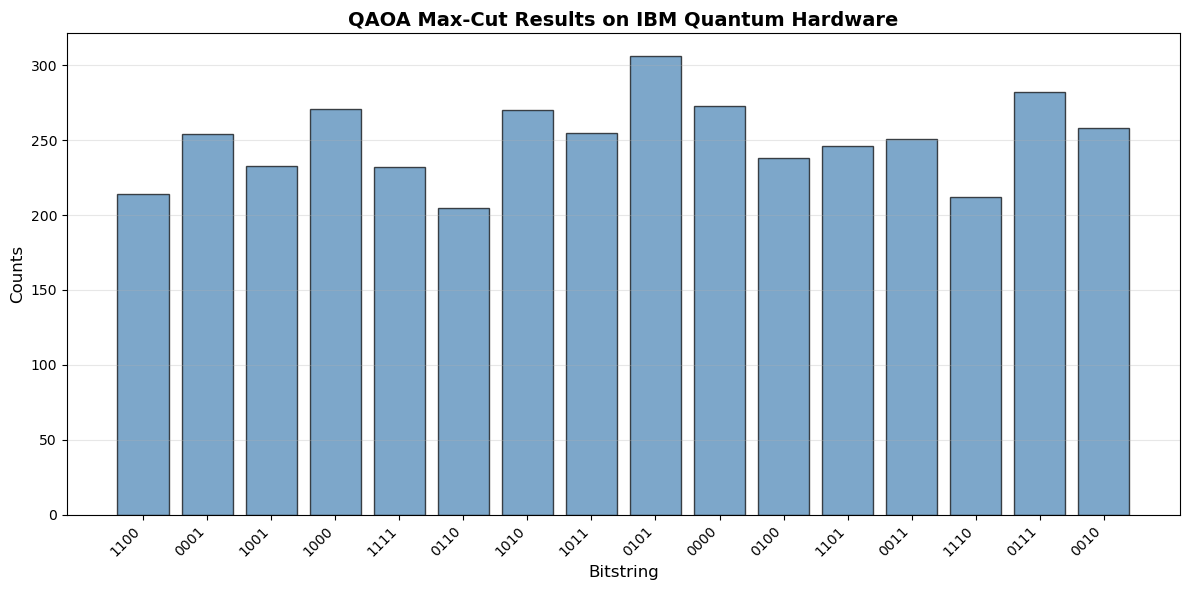


Total Shots: 4000
Unique Bitstrings: 16
Most Common Result: ('0101', 306)


In [46]:
# Visualize the measurement results in a histogram
import matplotlib.pyplot as plt

# Create histogram using matplotlib directly
fig, ax = plt.subplots(figsize=(12, 6))

bitstrings = list(counts_dict.keys())
counts = list(counts_dict.values())

ax.bar(range(len(bitstrings)), counts, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Bitstring', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('QAOA Max-Cut Results on IBM Quantum Hardware', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(bitstrings)))
ax.set_xticklabels(bitstrings, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
total_shots = sum(counts_dict.values())
print(f"\nTotal Shots: {total_shots}")
print(f"Unique Bitstrings: {len(counts_dict)}")
print(f"Most Common Result: {max(counts_dict.items(), key=lambda x: x[1])}")